# Main effects

In [2]:
library(tidyverse)
library(cowplot)

gwas <- read_tsv('~/projects/waffles/results/main_effects/plink.assoc.logistic', col_types = 'icdccdddd') %>%
    filter(TEST == 'ADD') %>%
    rename(chr = CHR, snp = SNP, pos = BP) %>%
    mutate(selected = ifelse(P < (0.05/n()), 'Yes', 'No')) %>%
    arrange(selected)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.4
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************




## Platform effect

In [49]:
gene2symbol <- read_tsv('~/projects/waffles/results/fuma_mapping/genes.tsv', col_types = 'ccicc') %>%
    select(ensg, symbol)
n_selected <- filter(gwas, selected == 'Yes') %>% nrow

get_n <- function(file, col_types) {
    
    snp2gene <- read_tsv(paste0('~/projects/waffles/results/fuma_mapping/', file), col_types = col_types) %>%
        select(rsID, ensg) %>%
        unique
    
    total <- group_by(snp2gene, ensg) %>%
        summarize(n_snps = n()) %>%
        arrange(-n_snps) %>%
        mutate(rank = 1:n())
    
    genes <- inner_join(gwas, snp2gene, by = c('snp' = 'rsID')) %>%
        filter(selected == 'Yes') %>%
        group_by(ensg) %>%
        summarize(hits = n())
    
    full_join(total, genes, by = 'ensg') %>%
        mutate(hits = ifelse(is.na(hits), 0, hits)) %>%
        left_join(gene2symbol, by = "ensg")
    
}

Warning message:
“Removed 52956 rows containing missing values (geom_point).”
Warning message:
“Removed 52956 rows containing missing values (geom_point).”


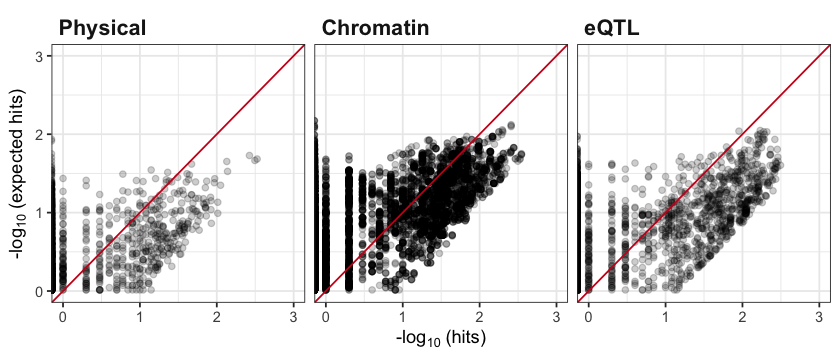

In [3]:
options(repr.plot.width=7, repr.plot.height=3)
bind_rows(get_n('physical_mapping.tsv', 'cccc') %>% mutate(mapping = 'Physical'),
          get_n('eqtl_mapping.tsv', 'ccc') %>% mutate(mapping = 'eQTL'),
          get_n('chromatin_interaction_mapping.tsv', 'cccc') %>% mutate(mapping = 'Chromatin')) %>%
    mutate(mapping = factor(mapping, levels = c('Physical', 'Chromatin', 'eQTL'))) %>%
    ggplot(aes(log10(hits), log10((n_selected * n_snps)/nrow(gwas)))) +
        geom_point(alpha=0.2) +
        geom_abline(slope = 1, color = '#cb181d') +
        facet_grid(~mapping) +
        scale_x_continuous(limits = c(0, 3)) +
        scale_y_continuous(limits = c(0, 3)) +
        labs(x = bquote('-log' [10]~'(hits)'),
             y = bquote('-log' [10]~'(expected hits)')) +
        theme_bw() +
        theme(strip.background = element_blank(),
              strip.text = element_text(size = 13, face = "bold", hjust=0))
ggsave('fig/main_effect_bias.png', width=7, height=3)

## Main effects influence on epistasis detection

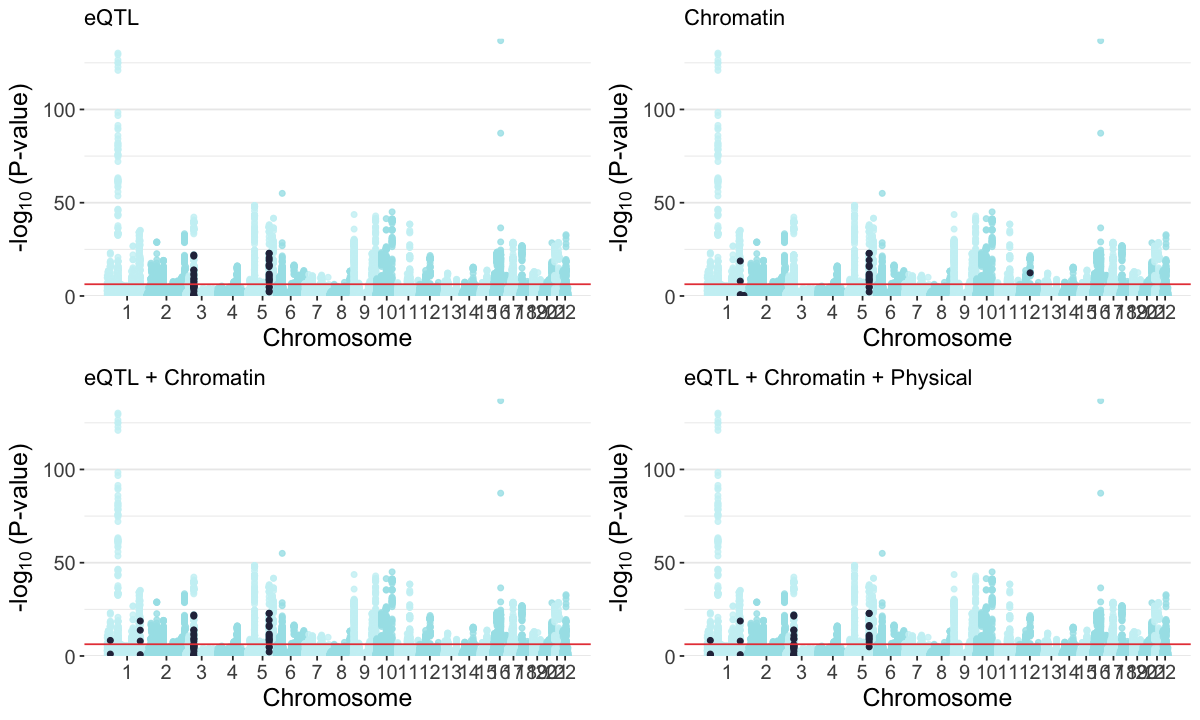

In [4]:
mh_plot <- function(protocol, tag) {

    gwais <- read_csv(paste0('../results/withBiofilter_filter/', protocol, '/sign_SNPpairs.txt'), col_types = 'ccdccc')
    epi_snps <- c(gwais$SNP_1, gwais$SNP_2) %>% unique

    don <- gwas %>% 

      # Compute chromosome size
      group_by(chr) %>% 
      summarise(chr_len=max(pos)) %>% 

      # Calculate cumulative position of each chromosome
      mutate(tot=cumsum(chr_len)-chr_len) %>%
      select(-chr_len) %>%

      # Add this info to the initial dataset
      left_join(gwas, ., by='chr') %>%

      # Add a cumulative position of each SNP
      arrange(chr, pos) %>%
      mutate(BPcum = pos + tot,
             epi_snp = snp %in% epi_snps)

    bf_threshold <- .05 / (nrow(gwas))
    y_lim <- max(-log10(don$P), na.rm = TRUE) + 1
    axisdf <- don %>% group_by(chr) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 )
    n_main <- filter(gwas, selected == 'Yes') %>% nrow
    n_epi <- length(epi_snps)

    ggplot(don, aes(x=BPcum, y=-log10(P))) +

        # Show all points
        geom_point( aes(color=as.factor(chr)), alpha=0.8, size=1.3) +
        scale_color_manual(values = rep(c("#cbf1f5", "#a6e3e9"), 22 )) +
        geom_point(data = filter(don, epi_snp), color='#2b2e4a', size=1.3) +

        # Add Bonferroni line
        geom_hline(yintercept = -log10(bf_threshold), color = '#e84545') +

        # custom X axis:
        scale_x_continuous( label = axisdf$chr, breaks= axisdf$center ) +
        scale_y_continuous(expand = c(0, 0), limits = c(0, y_lim)) +  # remove space between plot area and x axis

        # Custom the theme:
        theme_bw() +
        theme( 
          legend.position="none",
          panel.border = element_blank(),
          axis.title = element_text(size = 15),
          axis.text = element_text(size = 12),
          strip.text.y = element_text(size = 15),
          panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank()
        ) +
        labs(x = 'Chromosome', y = bquote('-log' [10] ~'(P-value)'), 
             title = tag)
    
    }

options(repr.plot.width=10, repr.plot.height=6)
plot_grid(mh_plot('eqtl', 'eQTL'), mh_plot('chromatin', 'Chromatin'),
          mh_plot('eqtl_chrom', 'eQTL + Chromatin'), mh_plot('eqtl_chrom_phys', 'eQTL + Chromatin + Physical'))

In [44]:
gtf <- read_tsv('../data/gencode.v33.annotation.gtf', comment = '#', col_names = F) %>%
    filter(X3 == 'gene') %>%
    mutate(ensg = gsub('gene_id "', '', X9),
           ensg = gsub('\\.[0-9]+".*', '', ensg),
           chr = gsub('chr', '', X1) %>% as.numeric) %>%
    rename(pos = X4) %>%
    select(ensg, chr, pos)

Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_character(),
  X3 = col_character(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_character(),
  X7 = col_character(),
  X8 = col_character(),
  X9 = col_character()
)

Warning message in function_list[[k]](value):
“NAs introduced by coercion”


Warning message:
“Removed 7 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


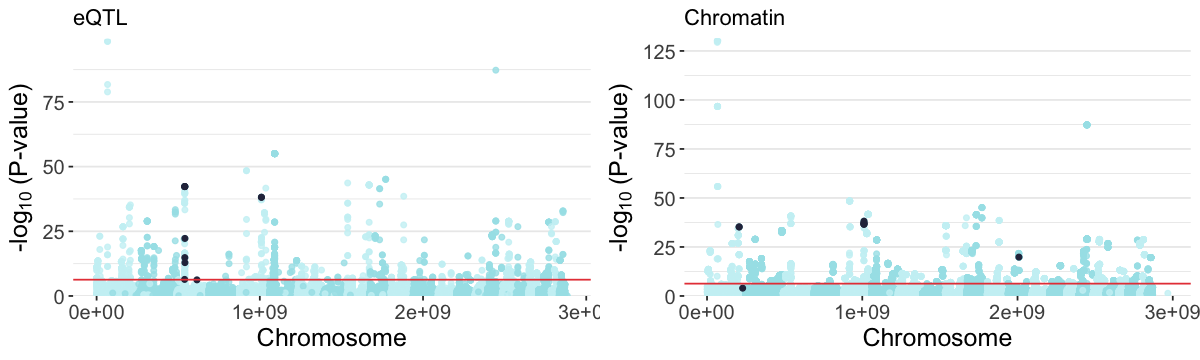

In [77]:
mh_plot <- function(protocol, tag, mapping) {

    gwais <- read_csv(paste0('../results/withBiofilter_filter/', protocol, '/sign_GenePairs_withoutThreshold.txt'), 
                      col_types = 'cdccd') %>%
        separate(genePairs_names, into = c('gene_a', 'gene_b'), sep = ' ')
    epi_genes <- gene2symbol$ensg[gene2symbol$symbol %in% c(gwais$gene_a, gwais$gene_b)] %>% unique

    snp2gene <- read_tsv(paste0('~/projects/waffles/results/fuma_mapping/', mapping, '.tsv'), 
                         col_types = cols(.default = 'c')) %>%
        inner_join(gtf, by = 'ensg') %>%
        select(rsID, ensg, chr, pos)

    don <- snp2gene %>%

      # Compute chromosome size
      group_by(chr) %>% 
      summarise(chr_len=max(pos)) %>% 

      # Calculate cumulative position of each chromosome
      mutate(tot=cumsum(chr_len)-chr_len) %>%
      select(-chr_len) %>%

      # Add this info to the initial dataset
      left_join(gwas, ., by='chr') %>%

      # gene-level
      inner_join(snp2gene, by = c('snp' = 'rsID'), suffix = c('_snp','_gene') ) %>%
      group_by(ensg, chr_gene, pos_gene, tot) %>%
      summarize(P = min(P)) %>%

      # Add a cumulative position of each SNP
      arrange(chr_gene, pos_gene) %>%
      mutate(BPcum = pos_gene + tot,
             epi_gene = ensg %in% epi_genes) %>%
      rename(chr = chr_gene, pos = pos_gene)

    bf_threshold <- .05 / (nrow(gwas))
    y_lim <- max(-log10(don$P), na.rm = TRUE) + 1
    axisdf <- don %>% group_by(chr) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 )
    n_main <- filter(gwas, selected == 'Yes') %>% nrow
    n_epi <- length(epi_genes)

    ggplot(don, aes(x=BPcum, y=-log10(P))) +

        # Show all points
        geom_point( aes(color=as.factor(chr)), alpha=0.8, size=1.3) +
        scale_color_manual(values = rep(c("#cbf1f5", "#a6e3e9"), 22 )) +
        geom_point(data = filter(don, epi_gene), color='#2b2e4a', size=1.3) +

        # Add Bonferroni line
        geom_hline(yintercept = -log10(bf_threshold), color = '#e84545') +

        # custom X axis:
#         scale_x_continuous( label = axisdf$chr, breaks= axisdf$center ) +
        scale_y_continuous(expand = c(0, 0), limits = c(0, y_lim)) +  # remove space between plot area and x axis

        # Custom the theme:
        theme_bw() +
        theme( 
          legend.position="none",
          panel.border = element_blank(),
          axis.title = element_text(size = 15),
          axis.text = element_text(size = 12),
          strip.text.y = element_text(size = 15),
          panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank()
        ) +
        labs(x = 'Chromosome', y = bquote('-log' [10] ~'(P-value)'), 
             title = tag)
    
}

options(repr.plot.width=10, repr.plot.height=3)
plot_grid(mh_plot('eqtl', 'eQTL','eqtl_mapping'), mh_plot('chromatin', 'Chromatin', 'chromatin_interaction_mapping'))